# Check easterlies separate zonal and meridional perturbations are working

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.colors as col
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/easterlies/perturbation_check/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

<Client: 'tcp://127.0.0.1:44625' processes=8 threads=48, memory=188.57 GiB>

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2155-12-31'
#start_time='2153-01-01'
#end_time='2155-12-31'

lat_slice  = slice(-80,-50)
lon_slice  = slice(-280, 80)

In [4]:
# main easterlies experiments
session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
easterlies_session = cc.database.create_session(session_name)

easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [5]:
# add new data to database:
session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
easterlies_session = cc.database.create_session(session_name)

dir_list = ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/',
           '/g/data/ik11/outputs/access-om2-01//01deg_jra55v13_ryf9091_easterlies_down10/',
           '/scratch/v45/akm157//access-om2/archive/01deg_jra55v13_ryf9091_easterlies_up10_noDSW/',
           '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10_zonal/',
           '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10_meridional/']
cc.database.build_index(dir_list,easterlies_session)

easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_down10


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10_noDSW


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10_zonal


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10_meridional


0it [00:00, ?it/s]


In [6]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

## Bottom age:

In [8]:
start_time='2150-01-01'
end_time='2155-12-31'

age_con = cc.querying.getvar(control,'age_global' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_con = age_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

age_up = cc.querying.getvar(easterlies_up,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_up = age_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

age_up_zonal = cc.querying.getvar(easterlies_up_zonal,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_up_zonal = age_up_zonal.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

age_up_meridional = cc.querying.getvar(easterlies_up_meridional,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_up_meridional = age_up_meridional.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

# select out bottom values:
depth_array = age_con * 0 + age_con.st_ocean
depth_array = depth_array.load()
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_age_con = age_con.where(depth_array.st_ocean >= max_depth)
bottom_age_con = bottom_age_con.sum(dim = 'st_ocean')
bottom_age_con = bottom_age_con.load()

bottom_age_up = age_up.where(depth_array.st_ocean >= max_depth)
bottom_age_up = bottom_age_up.sum(dim = 'st_ocean')
bottom_age_up = bottom_age_up.load()

bottom_age_up_zonal = age_up_zonal.where(depth_array.st_ocean >= max_depth)
bottom_age_up_zonal = bottom_age_up_zonal.sum(dim = 'st_ocean')
bottom_age_up_zonal = bottom_age_up_zonal.load()

bottom_age_up_meridional = age_up_meridional.where(depth_array.st_ocean >= max_depth)
bottom_age_up_meridional = bottom_age_up_meridional.sum(dim = 'st_ocean')
bottom_age_up_meridional = bottom_age_up_meridional.load()

In [15]:
# September only:

start_time='2150-01-01'
end_time='2156-12-31'

age_con = cc.querying.getvar(control,'age_global' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_con = age_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).groupby('time.month').mean('time').sel(month=9)                            

age_up = cc.querying.getvar(easterlies_up,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_up = age_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).groupby('time.month').mean('time').sel(month=9)                            

age_up_zonal = cc.querying.getvar(easterlies_up_zonal,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_up_zonal = age_up_zonal.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).groupby('time.month').mean('time').sel(month=9)                           

age_up_meridional = cc.querying.getvar(easterlies_up_meridional,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_up_meridional = age_up_meridional.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).groupby('time.month').mean('time').sel(month=9)                         

# select out bottom values:
depth_array = age_con * 0 + age_con.st_ocean
depth_array = depth_array.load()
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_age_con = age_con.where(depth_array.st_ocean >= max_depth)
bottom_age_con = bottom_age_con.sum(dim = 'st_ocean')
bottom_age_con = bottom_age_con.load()

bottom_age_up = age_up.where(depth_array.st_ocean >= max_depth)
bottom_age_up = bottom_age_up.sum(dim = 'st_ocean')
bottom_age_up = bottom_age_up.load()

bottom_age_up_zonal = age_up_zonal.where(depth_array.st_ocean >= max_depth)
bottom_age_up_zonal = bottom_age_up_zonal.sum(dim = 'st_ocean')
bottom_age_up_zonal = bottom_age_up_zonal.load()

bottom_age_up_meridional = age_up_meridional.where(depth_array.st_ocean >= max_depth)
bottom_age_up_meridional = bottom_age_up_meridional.sum(dim = 'st_ocean')
bottom_age_up_meridional = bottom_age_up_meridional.load()

In [9]:
# check what years have run so far:
#age_up_noDSW = cc.querying.getvar(easterlies_up_noDSW,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
#age_up_noDSW = age_up_noDSW.sel(time=slice(start_time,end_time))
#age_up_noDSW

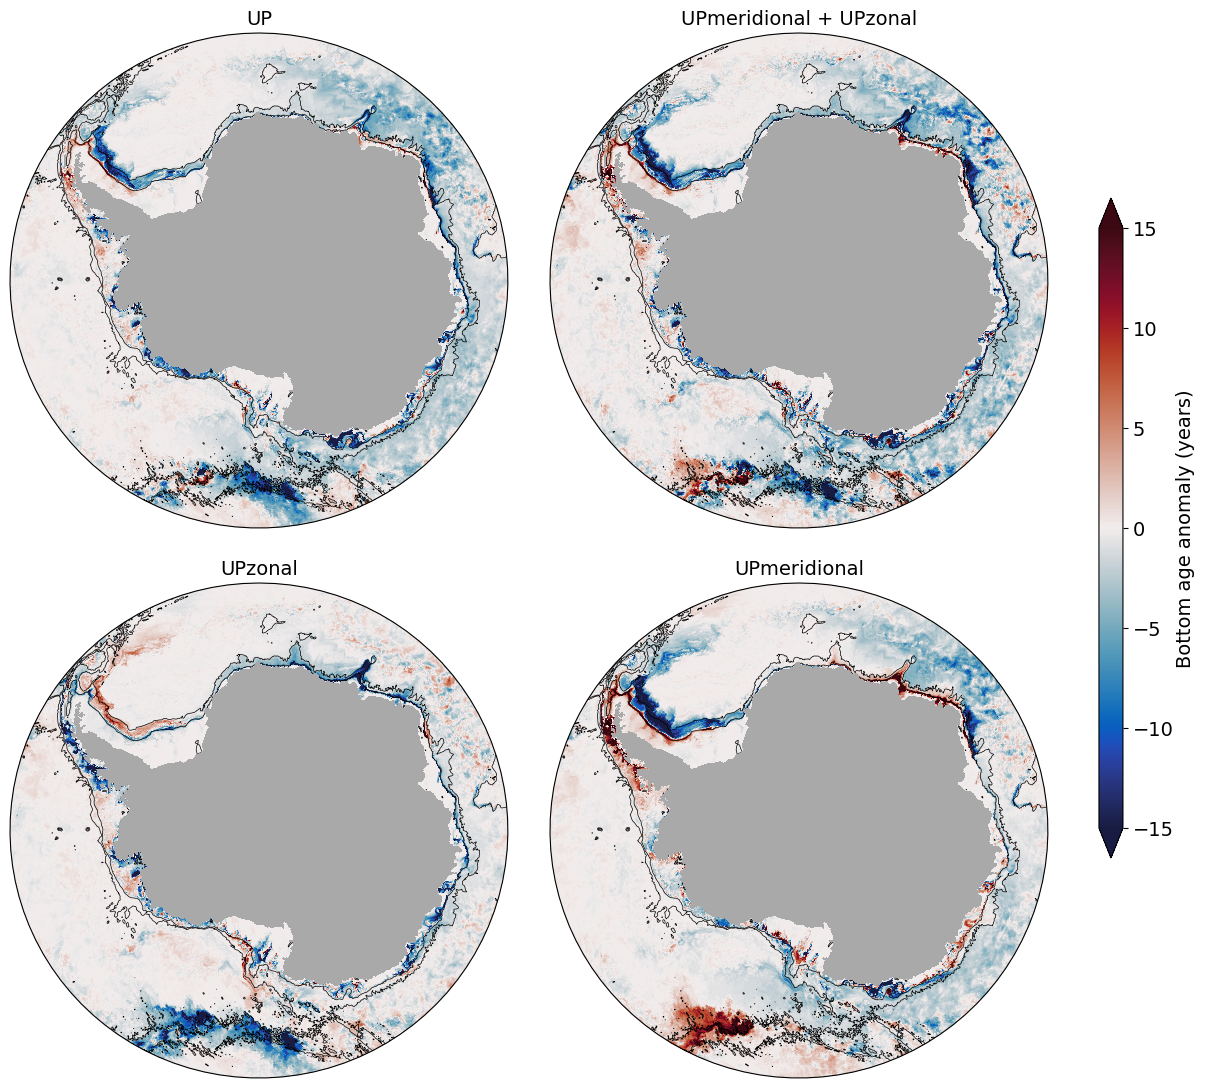

In [16]:
scale_max = 15

fig  = plt.figure(1, figsize = (12,11))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# up - control:
# setup stereo projection:
ax = fig.add_axes([0.0, 0.5, 0.5, 0.45],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_up-bottom_age_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('UP',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# meridional plus zonal minus control:
# setup stereo projection:
ax = fig.add_axes([0.45, 0.5, 0.5, 0.45],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, (bottom_age_up_meridional-bottom_age_con) + (bottom_age_up_zonal-bottom_age_con), norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('UPmeridional + UPzonal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# zonal - control:
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.5, 0.45],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_up_zonal-bottom_age_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('UPzonal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# meridional minus control:
# setup stereo projection:
ax = fig.add_axes([0.45, 0.0, 0.5, 0.45],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_up_meridional-bottom_age_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('UPmeridional',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([.95, 0.2, 0.02, 0.6])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom age anomaly (years)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# save:
figure_path = figdir+'zonal_meridional_bottom_age_maps_September.png'
fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)

## SSH time series:

In [41]:
# shelf masking:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [80]:
# load data:

# need to use a 20 year climatology of control:
start_time='2150-01-01'
end_time='2169-12-31'

# Control
SSH_con = cc.querying.getvar(control, 'sea_level', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
SSH_con = SSH_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

# Perturbation up
SSH_up = cc.querying.getvar(easterlies_up, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) 
SSH_up = SSH_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

end_time='2156-12-31'

# Perturbation zonal/meridional
SSH_up_zonal = cc.querying.getvar(easterlies_up_zonal, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
SSH_up_zonal = SSH_up_zonal.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

SSH_up_meridional = cc.querying.getvar(easterlies_up_meridional, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
SSH_up_meridional = SSH_up_meridional.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

SSH_up_nokatabatics = cc.querying.getvar(easterlies_up_noDSW, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
SSH_up_nokatabatics = SSH_up_nokatabatics.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

# get extra preceding year for control:
start_time='2149-01-01'
end_time='2149-12-31'

# Control
SSH_con_pre = cc.querying.getvar(control, 'sea_level', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
SSH_con_pre = SSH_con_pre.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

# shelf masking:

SSH_con, shelf_mask  = shelf_mask_isobath(SSH_con)
SSH_con_pre, shelf_mask  = shelf_mask_isobath(SSH_con_pre)
SSH_up, shelf_mask   = shelf_mask_isobath(SSH_up)
SSH_up_zonal, shelf_mask = shelf_mask_isobath(SSH_up_zonal)
SSH_up_meridional, shelf_mask = shelf_mask_isobath(SSH_up_meridional)
SSH_up_nokatabatics, shelf_mask = shelf_mask_isobath(SSH_up_nokatabatics)

In [81]:
# area weighting:
area_t = cc.querying.getvar(control,'area_t', master_session, ncfile='ocean_grid.nc', n=-1)
area_t = area_t.sel(yt_ocean=lat_slice)
area_t = area_t * shelf_mask.sel(yt_ocean=lat_slice)

area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# apply to data and area weight:
SSH_con  = (SSH_con*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
SSH_con_pre  = (SSH_con_pre*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
SSH_up   = (SSH_up*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
SSH_up_zonal = (SSH_up_zonal*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
SSH_up_meridional = (SSH_up_meridional*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
SSH_up_nokatabatics = (SSH_up_nokatabatics*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum

In [82]:
# Control monthly climatology:
SSH_con  = SSH_con.groupby('time.month').mean('time').values

n_years = int(len(SSH_up)/12)
SSH_con_full = np.vstack((SSH_con,) * n_years).reshape(n_years*12)

n_years_zonal = int(np.ceil(len(SSH_up_zonal)/12))
SSH_con_for_zonal = np.vstack((SSH_con,) * n_years_zonal).reshape(n_years_zonal*12)[:len(SSH_up_zonal)]

n_years_zonal = int(np.ceil(len(SSH_up_nokatabatics)/12))
SSH_con_for_nokatabatics = np.vstack((SSH_con,) * n_years_zonal).reshape(n_years_zonal*12)[:len(SSH_up_nokatabatics)]

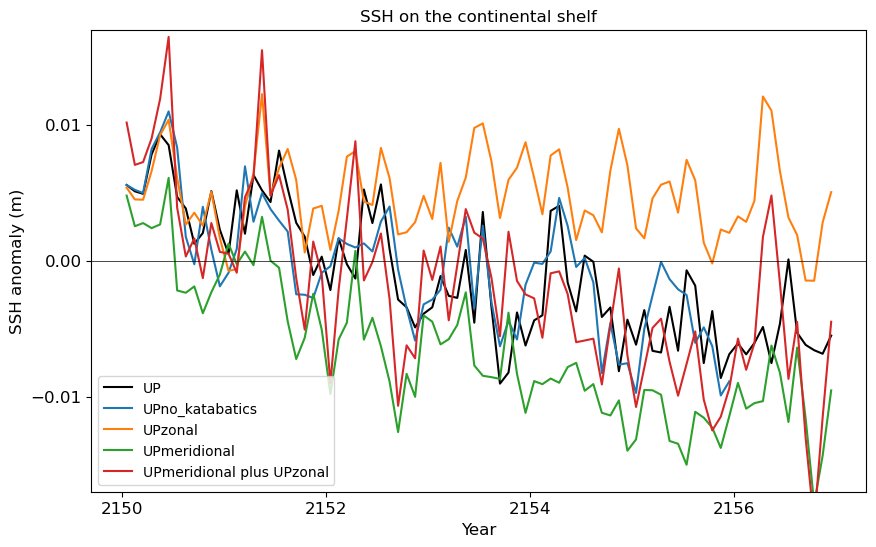

In [11]:
# plot:
fontsize = 12

fig = plt.figure(figsize=(10, 6))

# Monthly values
plt.plot(SSH_up.time[:len(SSH_up_zonal)], SSH_up[:len(SSH_up_zonal)] - SSH_con_full[:len(SSH_up_zonal)], color='k', label='UP')
plt.plot(SSH_up_nokatabatics.time, SSH_up_nokatabatics - SSH_con_for_nokatabatics, color='C0',label='UPno_katabatics')
plt.plot(SSH_up_zonal.time, SSH_up_zonal - SSH_con_for_zonal, color='C1', label='UPzonal')
plt.plot(SSH_up_meridional.time, SSH_up_meridional - SSH_con_for_zonal, color='C2', label='UPmeridional')
plt.plot(SSH_up_meridional.time, (SSH_up_meridional - SSH_con_for_zonal) + (SSH_up_zonal - SSH_con_for_zonal), 
         color='C3', label='UPmeridional plus UPzonal')
plt.ylim(-0.017, 0.017)
plt.yticks([-0.01, 0, 0.01])
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel('Year',fontsize=fontsize)
plt.ylabel('SSH anomaly (m)',fontsize=fontsize)
plt.title('SSH on the continental shelf',fontsize=fontsize)
plt.legend(ncol=1,loc=3)
plt.tick_params(labelsize=fontsize)


In [83]:
# testing
SSH_con_full = xr.DataArray(SSH_con_full, coords = [SSH_up.time], dims = ['time'])
SSH_con_for_zonal = xr.DataArray(SSH_con_for_zonal, coords = [SSH_up_zonal.time], dims = ['time'])
SSH_con_for_nokatabatics = xr.DataArray(SSH_con_for_nokatabatics, coords = [SSH_up_nokatabatics.time], dims = ['time'])

# compute anomalies:
SSH_up_anom = SSH_up - SSH_con_full
SSH_up_nokatabatics_anom = SSH_up_nokatabatics - SSH_con_for_nokatabatics
SSH_up_zonal_anom = SSH_up_zonal - SSH_con_full
SSH_up_meridional_anom = SSH_up_meridional - SSH_con_full

# append a year of zeros to start of time series:
SSH_up_anom = xr.concat([SSH_con_pre*0,SSH_up_anom],dim='time')
SSH_up_nokatabatics_anom = xr.concat([SSH_con_pre*0,SSH_up_nokatabatics_anom],dim='time')
SSH_up_zonal_anom = xr.concat([SSH_con_pre*0,SSH_up_zonal_anom],dim='time')
SSH_up_meridional_anom = xr.concat([SSH_con_pre*0,SSH_up_meridional_anom],dim='time')

# compute rolling means and convert to cm:
# Use 6 months rolling mean to keep some of the seasonality, but to remove the noise:
n_months = 6
rolling_mean_up = SSH_up_anom.rolling(time=n_months, center=True).mean()*100
rolling_mean_nokatabatic = SSH_up_nokatabatics_anom.rolling(time=n_months, center=True).mean()*100
rolling_mean_zonal = SSH_up_zonal_anom.rolling(time=n_months, center=True).mean()*100
rolling_mean_meridional = SSH_up_meridional_anom.rolling(time=n_months, center=True).mean()*100

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


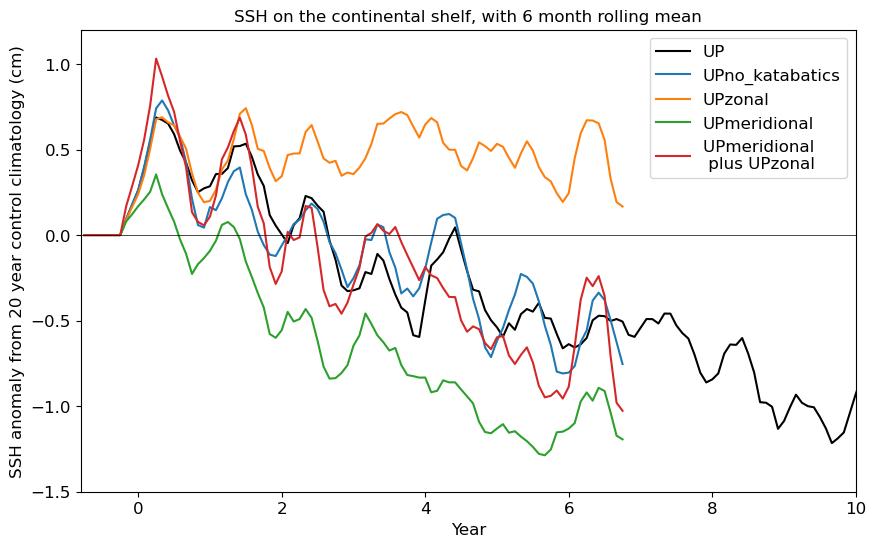

In [90]:
# plot with rolling means:

ntime = len(SSH_up.time)
n_years = (np.arange(ntime+1)/12)
    
fontsize = 12
fig = plt.figure(figsize=(10, 6))

ntime = len(SSH_up_anom.time)
n_years = (np.arange(ntime)/12)-1
plt.plot(n_years, rolling_mean_up, color='k', label='UP')
plt.plot(n_years[:len(SSH_up_nokatabatics_anom)], rolling_mean_nokatabatic , color='C0',label='UPno_katabatics')
plt.plot(n_years[:len(SSH_up_zonal_anom)], rolling_mean_zonal , color='C1', label='UPzonal')
plt.plot(n_years[:len(SSH_up_zonal_anom)], rolling_mean_meridional, color='C2', label='UPmeridional')
plt.plot(n_years[:len(SSH_up_zonal_anom)], (rolling_mean_meridional) + (rolling_mean_zonal), 
         color='C3', label='UPmeridional \n plus UPzonal')
plt.ylim(-1.5, 1.2)
plt.yticks([-1.5,-1,-.5, 0,.5, 1])
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel('Year',fontsize=fontsize)
plt.ylabel('SSH anomaly from 20 year control climatology (cm)',fontsize=fontsize)
plt.title('SSH on the continental shelf, with 6 month rolling mean',fontsize=fontsize)
plt.legend(ncol=1,loc=1,fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.xlim(-.8,10)

# save:
figure_path = figdir+'zonal_meridional_SSH_time_series.pdf'
fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)

## SWMT changes

In [91]:
start_time='2149-01-01'
end_time='2164-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# stitch together west and east sections:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_control_west = output.net_transformation_control
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_control_east = output.net_transformation_control
net_transformation_control = xr.concat([net_transformation_control_west,net_transformation_control_east],dim='xt_ocean')

start_time='2150-01-01'
end_time='2164-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# Note that I forgot to change the names of these variables when I saved them, but despite that they are for the correct simulations:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_up = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

#end_time='2155-12-31'
#time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_down_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_down_east = output.net_transformation_up1
net_transformation_down = xr.concat([net_transformation_down_west,net_transformation_down_east],dim='xt_ocean')

start_time='2150-01-01'
end_time='2155-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_east = output.net_transformation_up1
net_transformation_up_noDSW = xr.concat([net_transformation_up_noDSW_west,net_transformation_up_noDSW_east],dim='xt_ocean')

start_time='2150-01-01'
end_time='2156-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_zonal+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_zonal+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_zonal = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_meridional+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_meridional+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_meridional = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

### Time average plots:

In [10]:
# average over the 6 years: 
time_slice = slice(2150,2155)

area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

def plot_time_avg_SWMT(region):
    if region == 'Weddell':
        lat_slice  = slice(-77.5,-71)
        lon_slice  = slice(-62, -32)
        density = 27.84
    elif region == 'Adelie':
        lat_slice  = slice(-69,-65)
        lon_slice  = slice(-235, -210)
        density = 27.88
    elif region == 'Ross':
        lat_slice  = slice(-79,-72)
        lon_slice  = slice(-200, -165)
        density = 28.04
    elif region == 'Prydz':
        lat_slice  = slice(-69,-65)
        lon_slice  = slice(50, 75)
        density = 27.84

    # select area just for this DSW region:
    area_mask = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    
    swmt_sum_control = ((net_transformation_control.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up = ((net_transformation_up.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_down = ((net_transformation_down.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up_noDSW = ((net_transformation_up_noDSW.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up_zonal = ((net_transformation_zonal.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up_meridional = ((net_transformation_meridional.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    
    plt.plot(swmt_sum_control,swmt_sum_control.isopycnal_bins, 'k',linewidth=2,label='Control')
    plt.plot(swmt_sum_up,swmt_sum_up.isopycnal_bins, label='Up')
    plt.plot(swmt_sum_down,swmt_sum_down.isopycnal_bins, label='Down')
    plt.plot(swmt_sum_up_noDSW,swmt_sum_up_noDSW.isopycnal_bins, label='Up noDSW')
    plt.plot(swmt_sum_up_zonal,swmt_sum_up_zonal.isopycnal_bins, label='Up zonal')
    plt.plot(swmt_sum_up_meridional,swmt_sum_up_meridional.isopycnal_bins, label='Up meridional')
    plt.ylim((28.1, 27.52))
    plt.ylabel(r'$\sigma_{0}$ (kg m$^{-3}$)', fontsize = fontsize)
    plt.xlabel('Surface water mass transformation (Sv)', fontsize=fontsize)
    plt.legend(loc=4, ncol=2, fontsize = fontsize);
    plt.tick_params(labelsize=fontsize)
    plt.title(region+' SWMT, years 2150-2155', fontsize=fontsize);


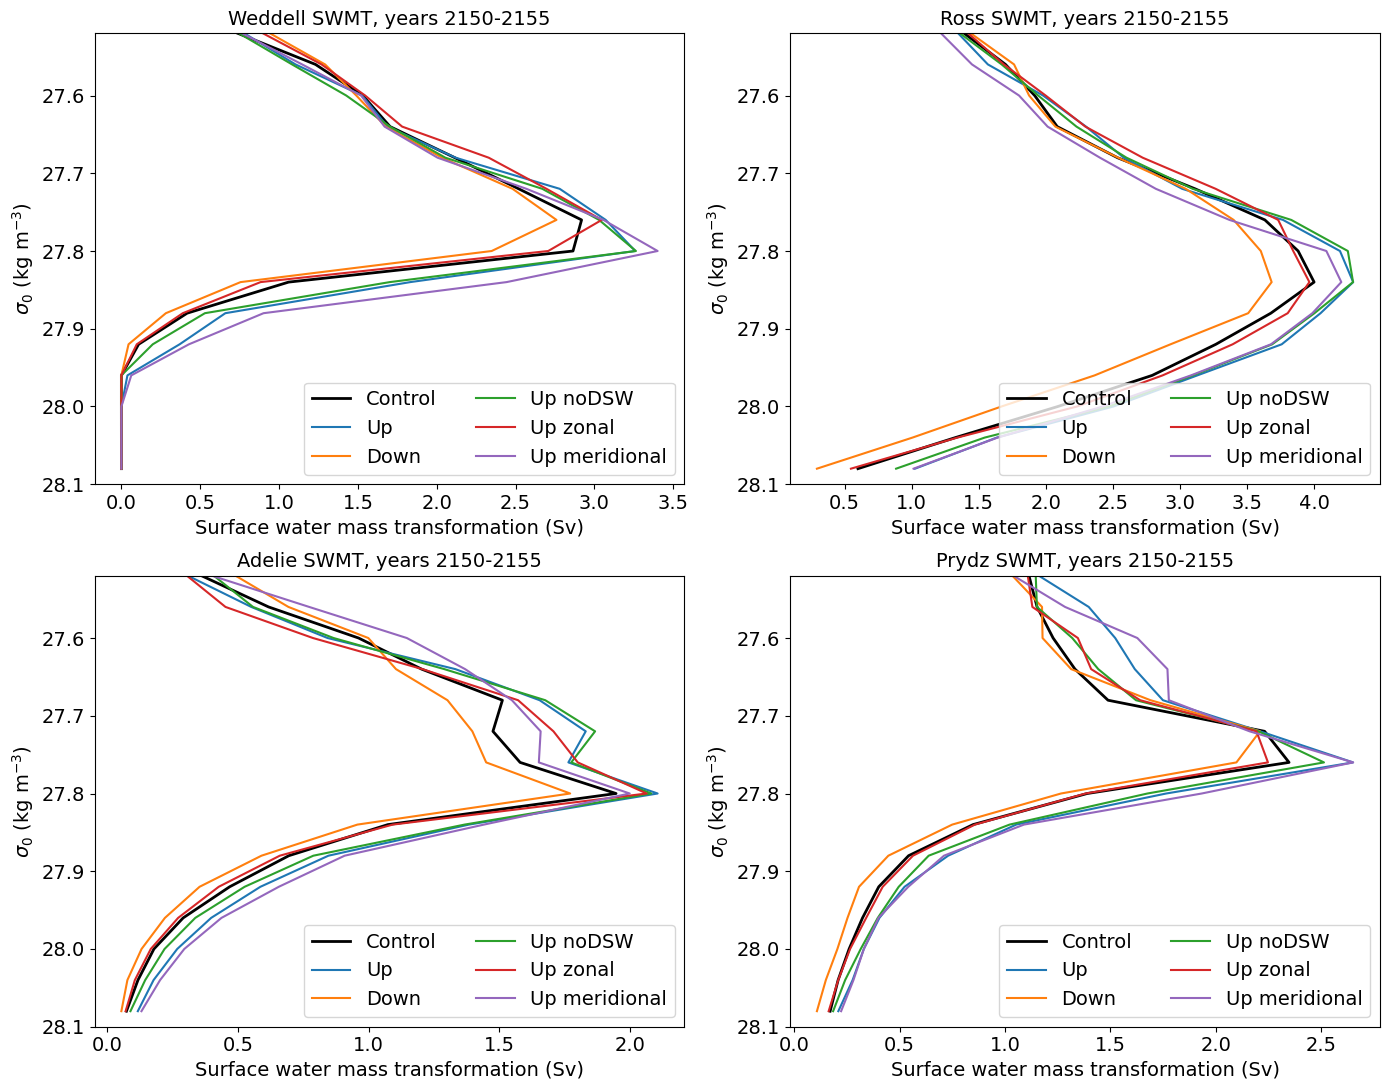

In [11]:
fontsize = 14
fig = plt.figure(num=1, figsize = (14, 11))

plt.subplot(2,2,1)
plot_time_avg_SWMT('Weddell')

plt.subplot(2,2,2)
plot_time_avg_SWMT('Ross')

plt.subplot(2,2,3)
plot_time_avg_SWMT('Adelie')

plt.subplot(2,2,4)
plot_time_avg_SWMT('Prydz')

plt.tight_layout()

### Plot timeseries of SWMT:

In [11]:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

def plot_time_series_SWMT(region):
    if region == 'Weddell':
        lat_slice  = slice(-77.5,-71)
        lon_slice  = slice(-62, -32)
        density = 27.84
    elif region == 'Adelie':
        lat_slice  = slice(-69,-65)
        lon_slice  = slice(-235, -210)
        density = 27.88
    elif region == 'Ross':
        lat_slice  = slice(-79,-72)
        lon_slice  = slice(-200, -165)
        density = 28.04
    elif region == 'Prydz':
        lat_slice  = slice(-69,-65)
        lon_slice  = slice(50, 75)
        density = 27.84

    # select area just for this DSW region:
    area_mask = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    
    # Extract single DSW region, multiply by area and sum over lat/lon, convert to Sv:
    swmt_control_timeseries = (net_transformation_control* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_up_timeseries = (net_transformation_up* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_down_timeseries = (net_transformation_down* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_up_noDSW_timeseries = (net_transformation_up_noDSW* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6  
    swmt_up_zonal_timeseries = (net_transformation_zonal* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_up_meridional_timeseries = (net_transformation_meridional* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
                              
    plt.plot(swmt_control_timeseries.year,swmt_control_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),
             'k',linewidth=2,label='Control')
    plt.plot(swmt_up_timeseries.year,swmt_up_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Up')
    plt.plot(swmt_down_timeseries.year,swmt_down_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Down')
    plt.plot(swmt_up_noDSW_timeseries.year,swmt_up_noDSW_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Up noDSW')
    plt.plot(swmt_up_zonal_timeseries.year,swmt_up_zonal_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Up zonal')
    plt.plot(swmt_up_meridional_timeseries.year,swmt_up_meridional_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),
             label='Up meridional')
    plt.xlabel(r'Year', fontsize = fontsize)
    plt.ylabel('Surface water mass transformation (Sv)', fontsize=fontsize)
    plt.legend(loc=4, ncol=1, fontsize = fontsize);
    plt.tick_params(labelsize=fontsize)
    plt.title(region+' SWMT at $\sigma_0$='+str(density), fontsize=fontsize);


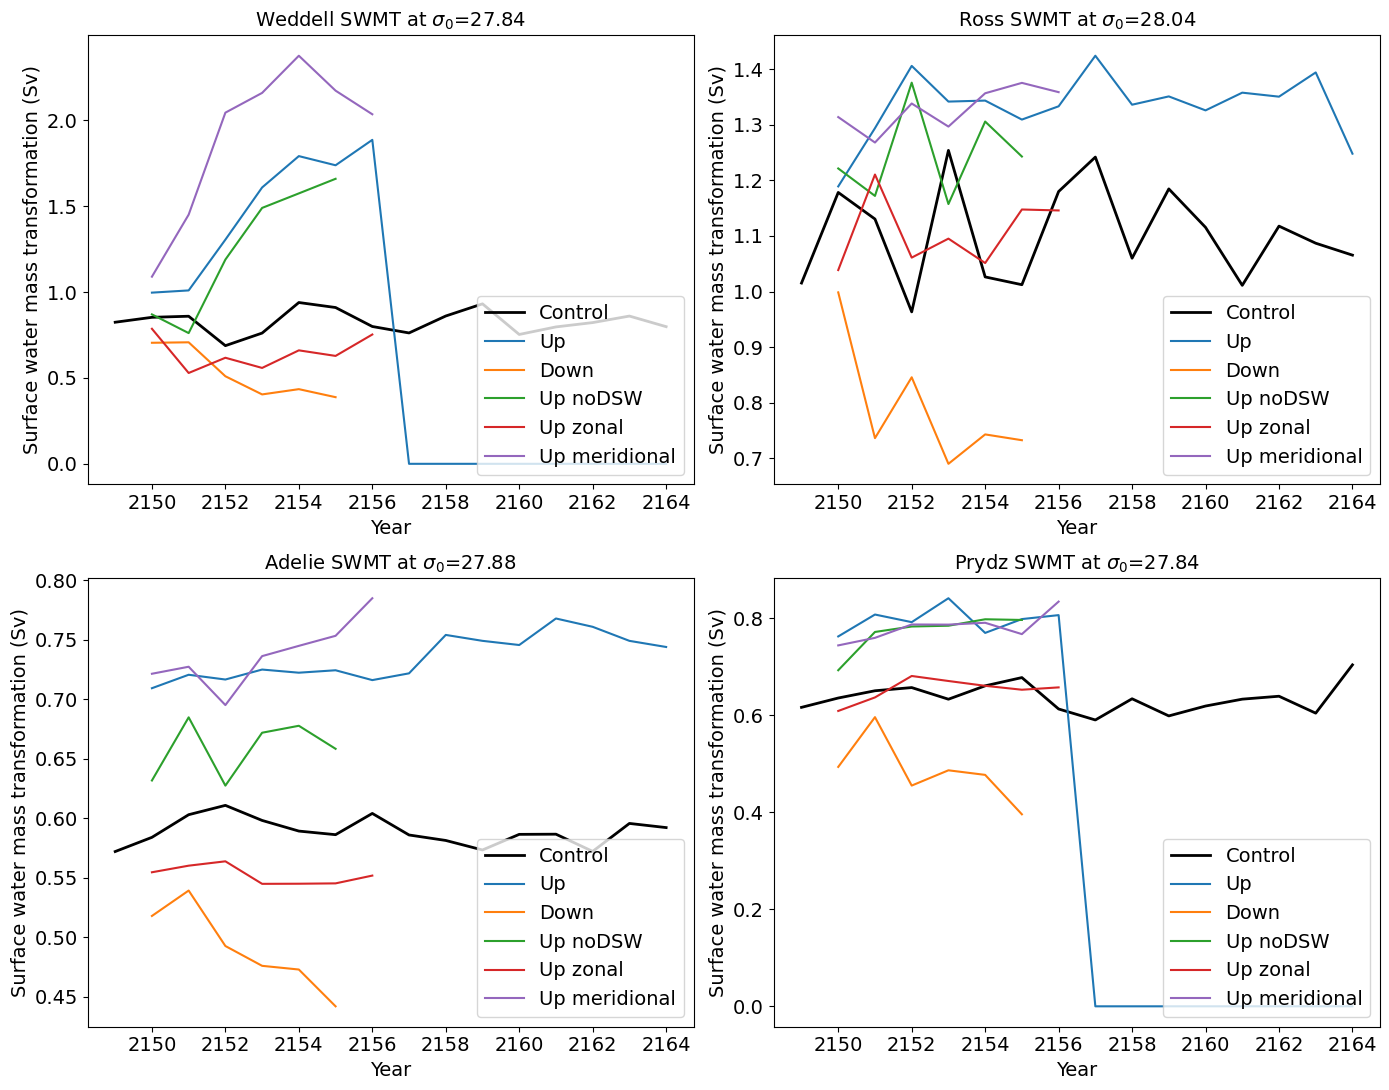

In [12]:
fontsize = 14
fig = plt.figure(num=1, figsize = (14, 11))

plt.subplot(2,2,1)
plot_time_series_SWMT('Weddell')

plt.subplot(2,2,2)
plot_time_series_SWMT('Ross')

plt.subplot(2,2,3)
plot_time_series_SWMT('Adelie')

plt.subplot(2,2,4)
plot_time_series_SWMT('Prydz')

plt.tight_layout()

In [101]:
# plot anomalies from long term control mean:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

def plot_time_series_SWMT(region):
    if region == 'Weddell':
        lat_slice  = slice(-77.5,-71)
        lon_slice  = slice(-62, -32)
        density = 27.84
    elif region == 'Adelie':
        lat_slice  = slice(-69,-65)
        lon_slice  = slice(-235, -210)
        density = 27.88
    elif region == 'Ross':
        lat_slice  = slice(-79,-72)
        lon_slice  = slice(-200, -165)
        density = 28.04
    elif region == 'Prydz':
        lat_slice  = slice(-69,-65)
        lon_slice  = slice(50, 75)
        density = 27.84

    # select area just for this DSW region:
    area_mask = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    
    # Extract single DSW region, multiply by area and sum over lat/lon, convert to Sv:
    swmt_control_mean = (net_transformation_control* area_mask).sum(['xt_ocean', 'yt_ocean']).mean('year').sel(isopycnal_bins=density,method='nearest')/1e6
    swmt_up_timeseries = (net_transformation_up* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_down_timeseries = (net_transformation_down* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_up_noDSW_timeseries = (net_transformation_up_noDSW* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6  
    swmt_up_zonal_timeseries = (net_transformation_zonal* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_up_meridional_timeseries = (net_transformation_meridional* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
                   
    ntime = len(swmt_up_timeseries.year)
    n_years = (np.arange(ntime+1))
    plt.plot(n_years,np.append(0,swmt_up_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze()-swmt_control_mean),label='Up')
    plt.plot(n_years,np.append(0,swmt_down_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze()-swmt_control_mean),label='Down')
    
    ntime = len(swmt_up_noDSW_timeseries.year)
    n_years = (np.arange(ntime+1))
    plt.plot(n_years,np.append(0,swmt_up_noDSW_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze()-swmt_control_mean),label='Up no_katabatics')
    
    ntime = len(swmt_up_zonal_timeseries.year)
    n_years = (np.arange(ntime+1))
    
    plt.plot(n_years,np.append(0,swmt_up_zonal_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze()-swmt_control_mean),label='Up zonal')
    plt.plot(n_years,np.append(0,swmt_up_meridional_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze()-swmt_control_mean),
             label='Up meridional')
    plt.xlabel(r'Year', fontsize = fontsize)
    plt.ylabel('Surface water mass transformation anomaly (Sv)', fontsize=fontsize)
    plt.legend(loc=5, ncol=1, fontsize = fontsize);
    plt.tick_params(labelsize=fontsize)
    plt.plot([-1,15],[0,0],'k',linewidth=0.5)
    plt.xlim(-.2,12)
    plt.title(region+' SWMT at $\sigma_0$='+str(density)+' , mean '+'{:.1f}'.format(swmt_control_mean.values)+' Sv', fontsize=fontsize);


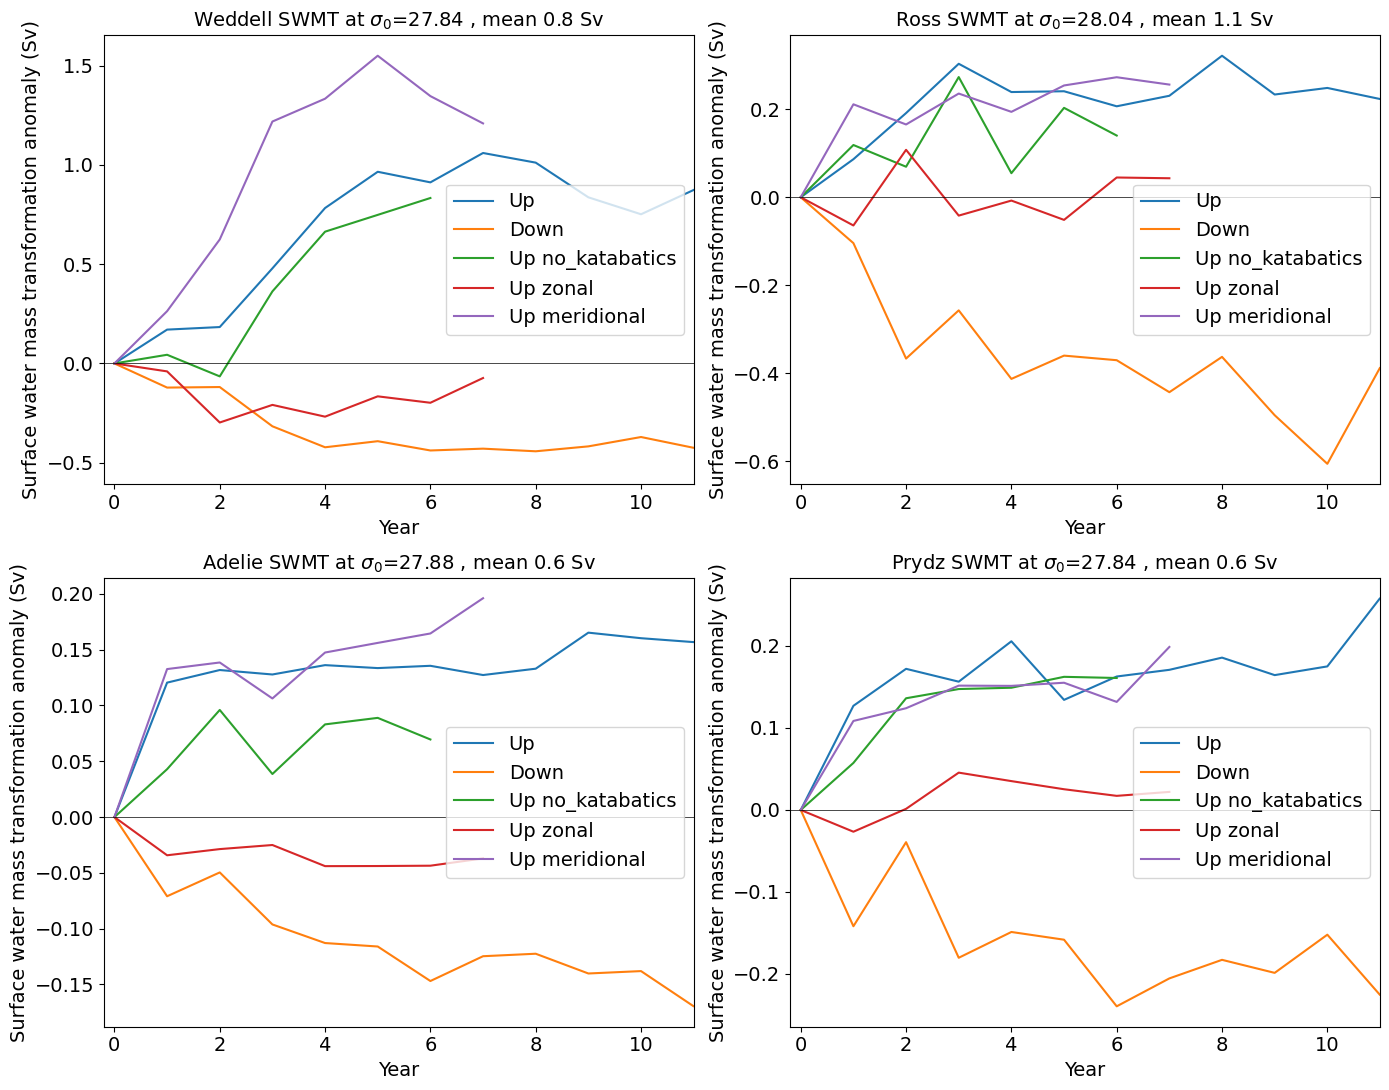

In [100]:
fontsize = 14
fig = plt.figure(num=1, figsize = (14, 11))

plt.subplot(2,2,1)
plot_time_series_SWMT('Weddell')

plt.subplot(2,2,2)
plot_time_series_SWMT('Ross')

plt.subplot(2,2,3)
plot_time_series_SWMT('Adelie')

plt.subplot(2,2,4)
plot_time_series_SWMT('Prydz')

plt.tight_layout()

# save:
figure_path = figdir+'zonal_meridional_SWMT_regions_time_series.pdf'
fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)

## Check wind stress perturbation:

In [11]:
tau_x_con = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_con = tau_x_con.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(control, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_con = tau_y_con.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

tau_x_up = cc.querying.getvar(easterlies_up, 'tau_x', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_up = tau_x_up.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_up = tau_x_up.load()

tau_y_up = cc.querying.getvar(easterlies_up, 'tau_y', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_up = tau_y_up.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_up = tau_y_up.load()

tau_x_up_zonal = cc.querying.getvar(easterlies_up_zonal, 'tau_x', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_up_zonal = tau_x_up_zonal.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_up_zonal = tau_x_up_zonal.load()

tau_y_up_zonal = cc.querying.getvar(easterlies_up_zonal, 'tau_y', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_up_zonal = tau_y_up_zonal.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_up_zonal = tau_y_up_zonal.load()

tau_x_up_meridional = cc.querying.getvar(easterlies_up_meridional, 'tau_x', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_up_meridional = tau_x_up_meridional.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_up_meridional = tau_x_up_meridional.load()

tau_y_up_meridional = cc.querying.getvar(easterlies_up_meridional, 'tau_y', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_up_meridional = tau_y_up_meridional.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_up_meridional = tau_y_up_meridional.load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23133379188544 and this is thread id 23130775373568.
Exception closing connection <sqlite3.Connection object at 0x15096e4c47b0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/po

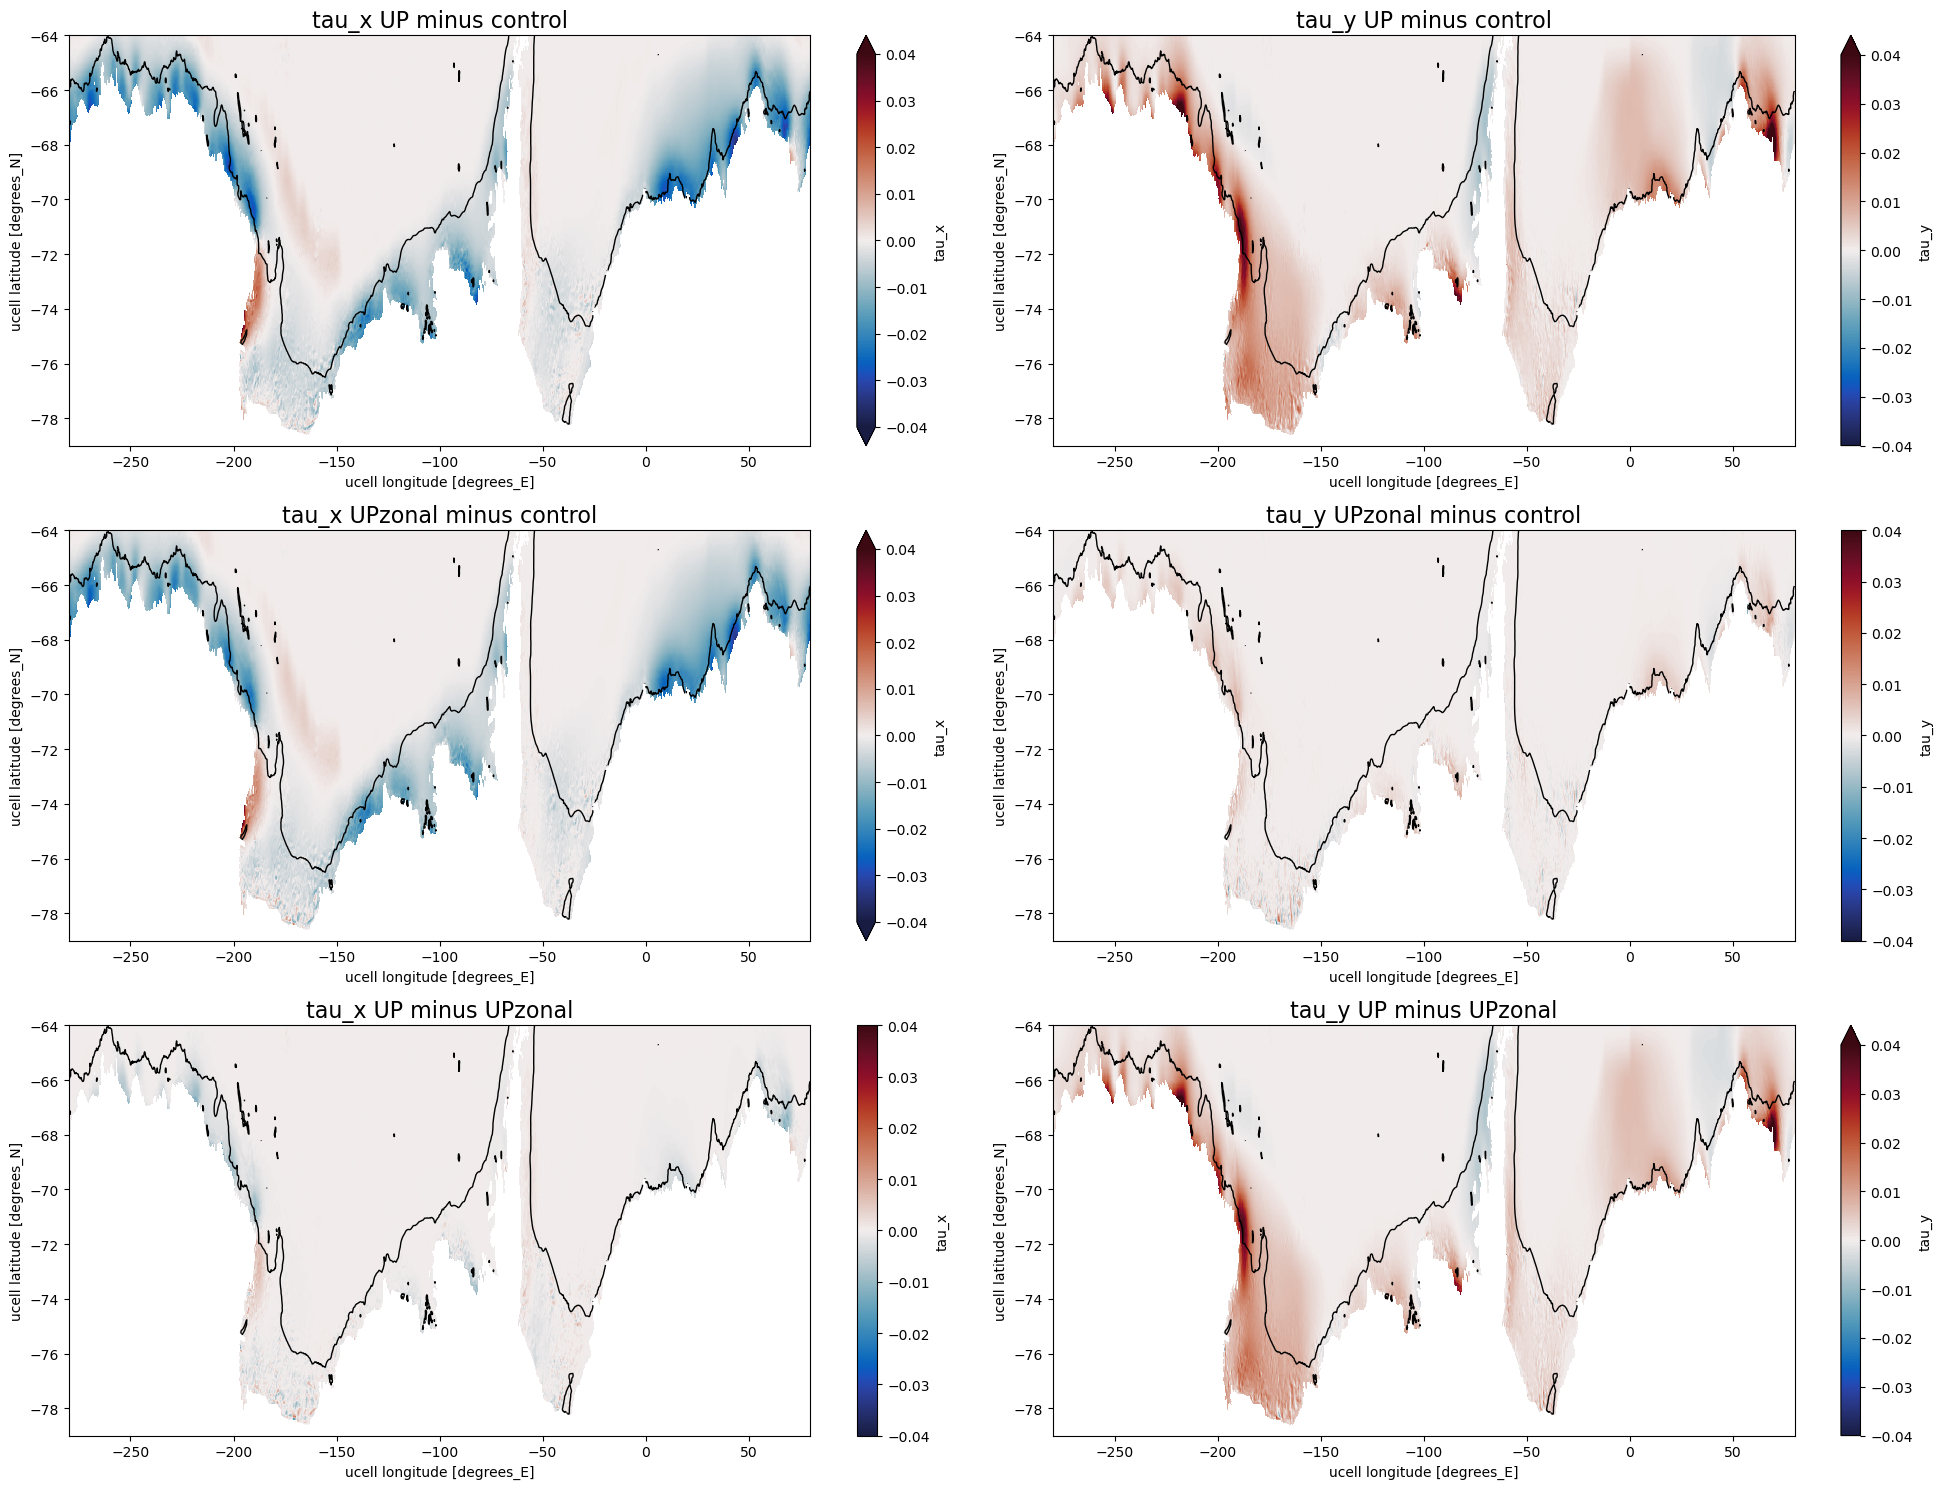

In [13]:
# plot UPzonal wind changes

plt.figure(figsize=(20,15))

scale_max = 0.04

plt.subplot(3,2,1)
(tau_x_up  - tau_x_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_x UP minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,2)
(tau_y_up - tau_y_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_y UP minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,3)
(tau_x_up_zonal  - tau_x_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_x UPzonal minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,4)
(tau_y_up_zonal - tau_y_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_y UPzonal minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,5)
(tau_x_up - tau_x_up_zonal).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_x UP minus UPzonal',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,6)
(tau_y_up - tau_y_up_zonal ).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_y UP minus UPzonal',fontsize=fontsize)
plt.ylim(-79,-64)

plt.tight_layout()

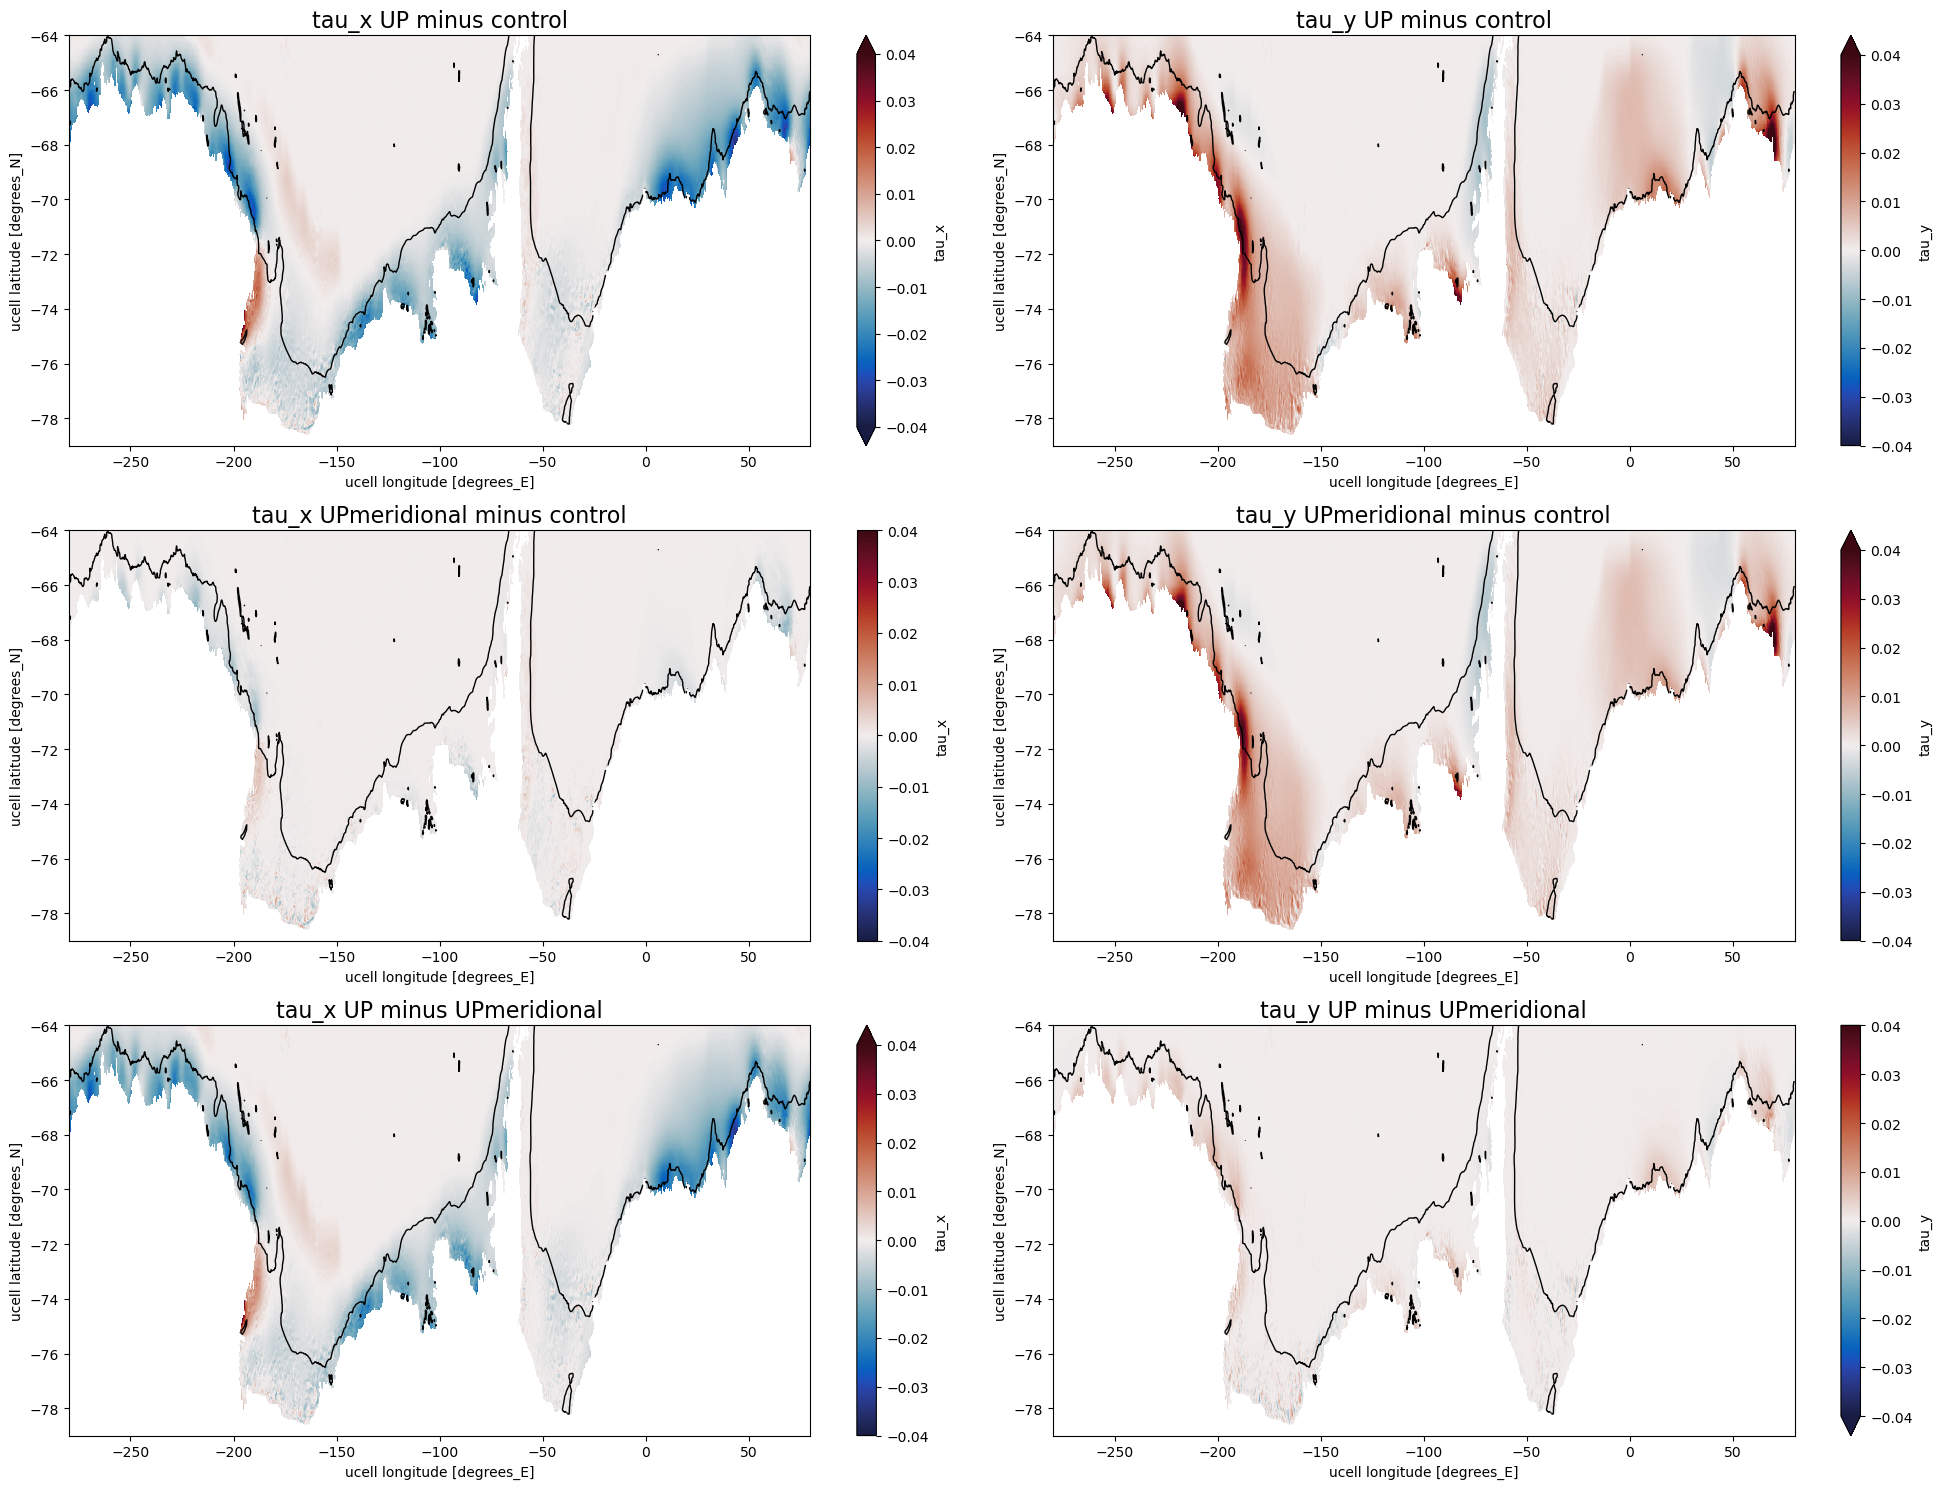

In [15]:
# plot UPmeridional wind changes

plt.figure(figsize=(20,15))

scale_max = 0.04

plt.subplot(3,2,1)
(tau_x_up  - tau_x_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_x UP minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,2)
(tau_y_up - tau_y_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_y UP minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,3)
(tau_x_up_meridional  - tau_x_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_x UPmeridional minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,4)
(tau_y_up_meridional - tau_y_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_y UPmeridional minus control',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,5)
(tau_x_up - tau_x_up_meridional).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_x UP minus UPmeridional',fontsize=fontsize)
plt.ylim(-79,-64)

plt.subplot(3,2,6)
(tau_y_up - tau_y_up_meridional ).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.title('tau_y UP minus UPmeridional',fontsize=fontsize)
plt.ylim(-79,-64)

plt.tight_layout()

## SWMT changes

In [11]:
start_time='2150-01-01'
end_time='2155-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# stitch together west and east sections:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
control_output = xr.open_dataset(outpath)
net_transformation_control_west = control_output.net_transformation_control
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
control_output = xr.open_dataset(outpath)
net_transformation_control_east = control_output.net_transformation_control
net_transformation_control = xr.concat([net_transformation_control_west,net_transformation_control_east],dim='xt_ocean')

# Note that I forgot to change the names of these variables when I saved them, but despite that they are for the correct simulations:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
up_output = xr.open_dataset(outpath)
net_transformation_up_west = up_output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
up_output = xr.open_dataset(outpath)
net_transformation_up_east = up_output.net_transformation_up1
net_transformation_up = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
noDSW_output = xr.open_dataset(outpath)
net_transformation_up_noDSW_west = noDSW_output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
noDSW_output = xr.open_dataset(outpath)
net_transformation_up_noDSW_east = noDSW_output.net_transformation_up1
net_transformation_up_noDSW = xr.concat([net_transformation_up_noDSW_west,net_transformation_up_noDSW_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
down_output = xr.open_dataset(outpath)
net_transformation_down_west = down_output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
down_output = xr.open_dataset(outpath)
net_transformation_down_east = down_output.net_transformation_up1
net_transformation_down = xr.concat([net_transformation_down_west,net_transformation_down_east],dim='xt_ocean')